# Instalar dependencias

In [2]:
!pip install cython
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 20.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 45.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 51.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |█████████████████████

In [3]:
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

Selecting previously unselected package python-pkg-resources.
(Reading database ... 155685 files and directories currently installed.)
Preparing to unpack .../00-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../01-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../02-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../03-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../04-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-numpy.
Preparing to unpack .../05-python

In [4]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 4.3 MB/s 


In [5]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import cm

import cartopy
import cartopy.crs as ccrs                   # for projections
import cartopy.feature as cfeature           # for features
import cartopy.io.shapereader as shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature.nightshade import Nightshade

In [6]:
import pandas as pd
import pyproj
from math import sqrt, ceil, floor, e as euler, pi
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import urllib.request

# Variables

In [7]:
function_number = 1 # Even, Triangular, Gaussian, Epanechnikov, Variance
bandwith = 100
resolution = 10
interval = ceil(bandwith/resolution)

# Df

In [8]:
url = 'https://foscalinternacional.com/datasets/eventos_dengue_2020.csv'
df = pd.read_csv(url)

In [9]:
df = df.drop('ID', axis=1)

In [10]:
def set_datetime(column):
  df[column] = pd.to_datetime(df[column], format='%d/%m/%Y')

In [11]:
columns = ['fec_not', 'fecha_contagio', 'inicio_sintomas', 'fecha_nacimiento']

In [12]:
for column in columns:
  set_datetime(column)

# Pyproj

In [13]:
P = pyproj.Proj(proj='utm', zone=18, elips='WGS84', preserve_units=True)

In [14]:
df['x'], df['y'] = P(df['longitud'], df['latitud'])

# Añadir distancia de la alcaldía

In [15]:
x_alcaldia, y_alcaldia = P(-73.086038, 7.062898)

In [16]:
df['distancia'] = None

In [17]:
for i in range(df.shape[0]):
  df.loc[i, 'distancia'] = sqrt(((df['x'][i] - x_alcaldia)**2) + ((df['y'][i] - y_alcaldia)**2))

# Correlacion

In [18]:
df2 = df
df2 = df2.select_dtypes(exclude=['object', 'datetime64'])
df2 = df2.drop(['año', 'cod_pais_o', 'condicion_final', 'fecha_defuncion', 'certif_defuncion'], axis=1)

In [19]:
'''
colormap = plt.cm.viridis
plt.figure(figsize=(24,24))
plt.title('Pearson Correlation', y=1.05, size=15)
sb.heatmap(df2.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
'''

"\ncolormap = plt.cm.viridis\nplt.figure(figsize=(24,24))\nplt.title('Pearson Correlation', y=1.05, size=15)\nsb.heatmap(df2.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)\n"

# Mapa de calor


In [20]:
bandwith = 100
resolution = 10
interval = ceil(bandwith/resolution)

min_x = min(df['x']) - bandwith
max_x = max(df['x']) + bandwith
min_y = min(df['y']) - bandwith
max_y = max(df['y']) + bandwith

len_x = ceil((max_x - min_x) / resolution)
len_y = ceil((max_y - min_y) / resolution)

matrix = [[0 for x in range(len_x)] for y in range(len_y)]

In [21]:
for i in range(df.shape[0]):
  pos_x = floor((df.loc[i, 'x'] - min_x) / resolution)
  pos_y = floor((df.loc[i, 'y'] - min_y) / resolution)
  matrix[pos_y][pos_x] += 1

In [22]:
'''
fig = plt.figure(figsize=(50, 40))

ax = fig.add_subplot(111)
ax.set_title('Mapa de calor')
plt.imshow(matrix)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()
'''

"\nfig = plt.figure(figsize=(50, 40))\n\nax = fig.add_subplot(111)\nax.set_title('Mapa de calor')\nplt.imshow(matrix)\nax.set_aspect('equal')\n\ncax = fig.add_axes([0.12, 0.1, 0.78, 0.8])\ncax.get_xaxis().set_visible(False)\ncax.get_yaxis().set_visible(False)\ncax.patch.set_alpha(0)\ncax.set_frame_on(False)\nplt.colorbar(orientation='vertical')\nplt.show()\n"

# Poner la densidad sin función de agrupación


## Metodo 1

In [23]:
'''
matrix_acc = [[0 for x in range(len_x)] for y in range(len_y)]
for i in range(len(matrix)):
  for j in range(len(matrix[i])):
    i_lower = i-interval if i >= interval else 0
    i_upper = i+interval if i <= len(matrix)-interval else len(matrix)
    j_lower = j-interval if j >= interval else 0
    j_upper = j+interval if j <= len(matrix[i])-interval else len(matrix[i])
    for k in range(i_lower, i_upper):
      for l in range(j_lower, j_upper):
        distance = sqrt(((i-k)**2) + ((j-l)**2)) * resolution
        if distance <= bandwith:
          matrix_acc[i][j] += matrix[k][l]
'''

'\nmatrix_acc = [[0 for x in range(len_x)] for y in range(len_y)]\nfor i in range(len(matrix)):\n  for j in range(len(matrix[i])):\n    i_lower = i-interval if i >= interval else 0\n    i_upper = i+interval if i <= len(matrix)-interval else len(matrix)\n    j_lower = j-interval if j >= interval else 0\n    j_upper = j+interval if j <= len(matrix[i])-interval else len(matrix[i])\n    for k in range(i_lower, i_upper):\n      for l in range(j_lower, j_upper):\n        distance = sqrt(((i-k)**2) + ((j-l)**2)) * resolution\n        if distance <= bandwith:\n          matrix_acc[i][j] += matrix[k][l]\n'

## Metodo 2

In [24]:
matrix_acc = [[0 for x in range(len_x)] for y in range(len_y)]
for i in range(len(matrix)):
  for j in range(len(matrix[i])):
    if matrix[i][j] != 0:
      i_lower = i-interval if i >= interval else 0
      i_upper = i+interval if i <= len(matrix)-interval else len(matrix)
      j_lower = j-interval if j >= interval else 0
      j_upper = j+interval if j <= len(matrix[i])-interval else len(matrix[i])
      for k in range(floor(i_lower), ceil(i_upper)):
        for l in range(floor(j_lower), ceil(j_upper)):
          distance = sqrt(((i-k)**2) + ((j-l)**2)) * resolution
          if distance <= bandwith:
            matrix_acc[k][l] += matrix[i][j]

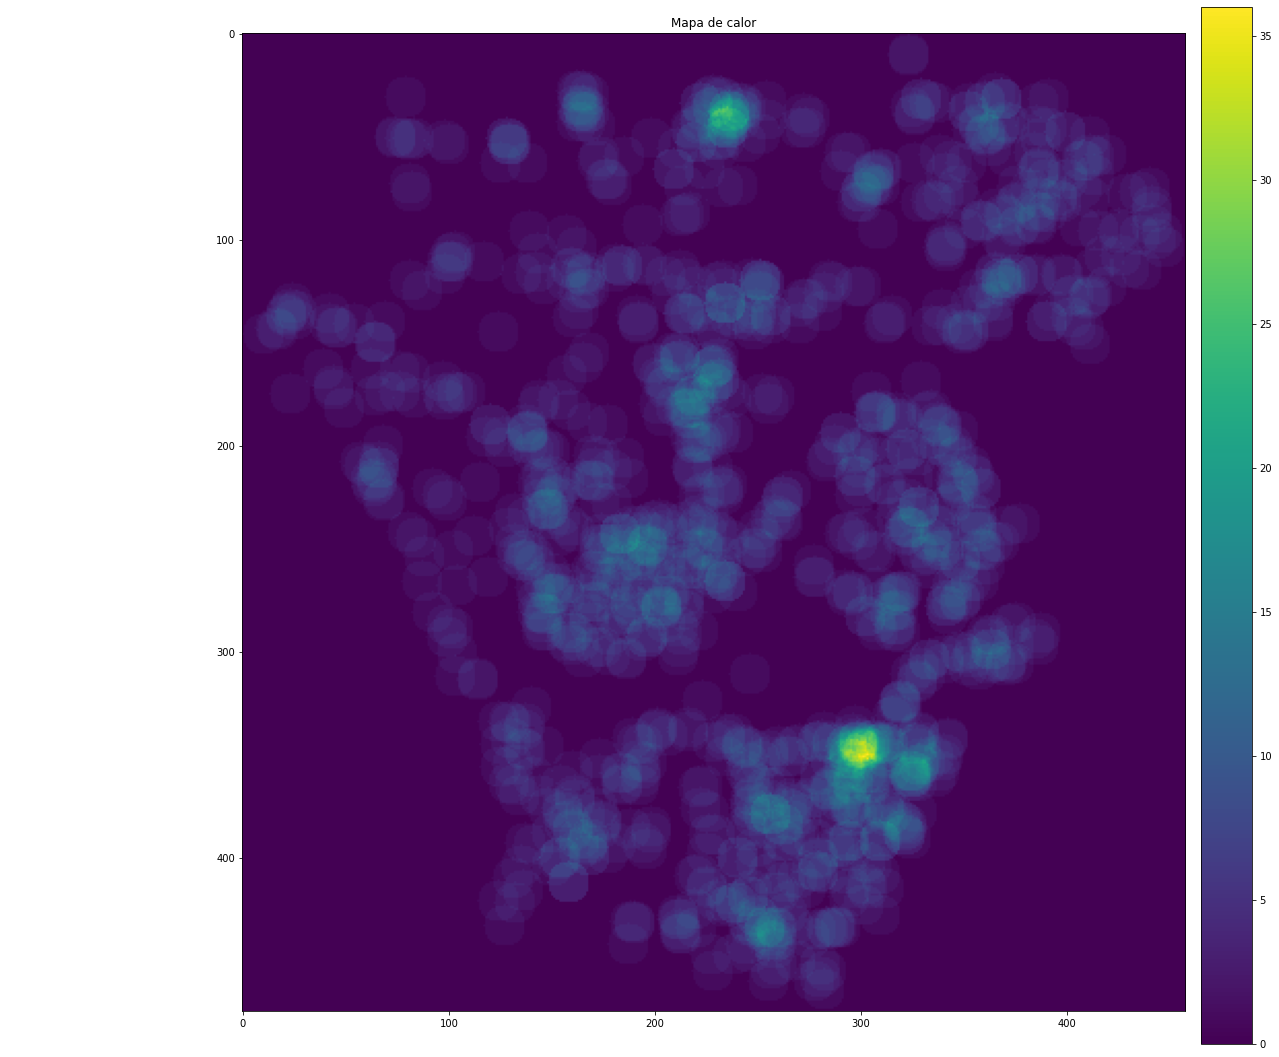

In [25]:
fig = plt.figure(figsize=(25, 18))

ax = fig.add_subplot(111)
ax.set_title('Mapa de calor')
plt.imshow(matrix_acc)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical', pad=0.2)
plt.show()

# Poner densidad con función de agrupación


## Función de agrupación

In [26]:
class DensityFunction():
  def __init__(self, x, bandwith):
    self.x = x
    self.bandwith = bandwith
  
  def calculate_function(self, n: int):
    if n == 1:
      return self._even()
    elif n == 2:
      return self._triangular()
    elif n == 3:
      return self._gaussian()
    elif n == 4:
      return self._epanechnikov()
    elif n == 5:
      return self._variance()

  def _get_x(self):
    return abs(self.x/self.bandwith)

  def _even(self):
    y = 0.5
    return y
  
  def _triangular(self):
    y = 1 - abs(self._get_x())
    return y

  def _gaussian(self):
    y = (euler**-((self._get_x()/2)**2))/sqrt(2*pi)
    return y

  def _epanechnikov(self):
    y = (3/4)*(1-(self._get_x()**2))
    return y

  def _variance(self):
    y = (3/8)*(3-(5*(self._get_x())**2))
    return y


In [27]:
matrix_acc = [[0 for x in range(len_x)] for y in range(len_y)]
for i in range(len(matrix)):
  for j in range(len(matrix[i])):
    if matrix[i][j] != 0:
      i_lower = i-interval if i >= interval else 0
      i_upper = i+interval if i <= len(matrix)-interval else len(matrix)
      j_lower = j-interval if j >= interval else 0
      j_upper = j+interval if j <= len(matrix[i])-interval else len(matrix[i])
      for k in range(floor(i_lower), ceil(i_upper)):
        for l in range(floor(j_lower), ceil(j_upper)):
          distance = sqrt(((i-k)**2) + ((j-l)**2)) * resolution
          if distance <= bandwith:
            density_group = DensityFunction(distance, bandwith)
            for m in range(matrix[i][j]):
              matrix_acc[k][l] += density_group.calculate_function(function_number)

var = pi * bandwith**2
for i in range(len(matrix_acc)):
  for j in range(len(matrix_acc[i])):
    matrix_acc[i][j] = matrix_acc[i][j]/var 


In [28]:
import colorsys

In [29]:
def generar_gama(ri, gi, bi, rf, gf, bf, cantidad):
  hsvi = colorsys.rgb_to_hsv(ri/255, gi/255, bi/255)
  hsvf = colorsys.rgb_to_hsv(rf/255, gf/255, bf/255)

  pasoh = (hsvf[0]- hsvi[0]) / (cantidad - 1)
  pasos = (hsvf[1]- hsvi[1]) / (cantidad - 1)
  pasov = (hsvf[2]- hsvi[2]) / (cantidad - 1)

  listaRGB = []
  listaRGB.append((ri/255, gi/255, bi*255))
  for i in range(cantidad-1):
    h = hsvi[0] + pasoh * (i+1)
    v = hsvi[1] + pasos * (i+1)
    s = hsvi[2] + pasov * (i+1)

    rgb = colorsys.hsv_to_rgb(h, s, v)
    listaRGB.append(rgb)
  return listaRGB

In [30]:
gama = generar_gama(220, 30, 35, 10, 10, 10, 5)
gama

[(0.8627450980392157, 0.11764705882352941, 8925),
 (0.42659592245989314, 0.22225935828877005, 0.6477272727272727),
 (0.23707664884135474, 0.4318181818181818, 0.4292557932263815),
 (0.18979779411764708, 0.21590909090909094, 0.1629901960784314),
 (0.0, 0.0, 0.0)]

# Visualizar

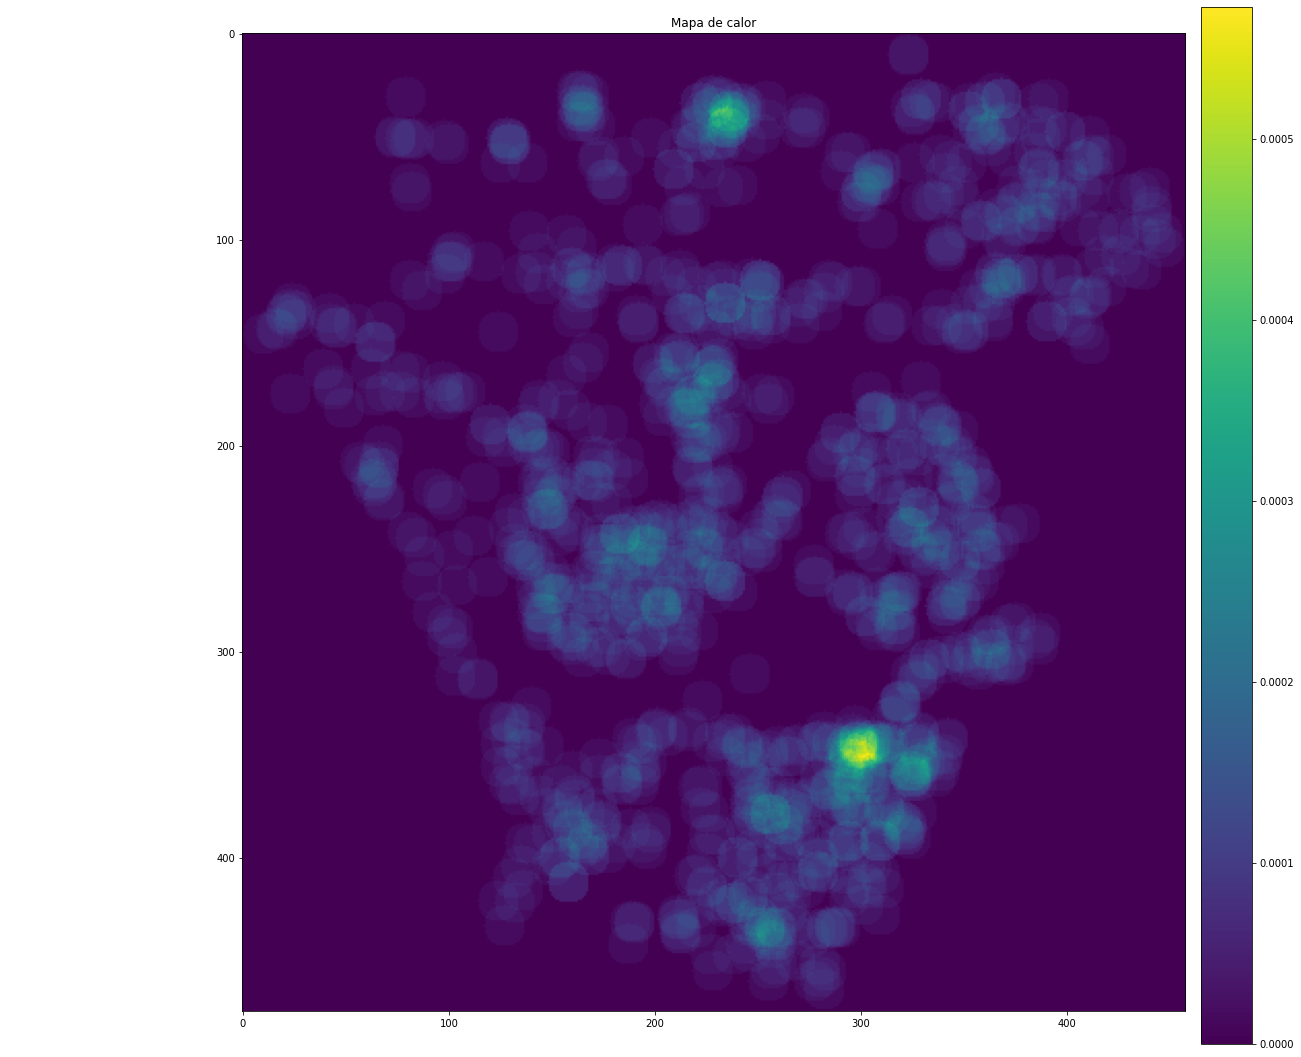

In [31]:
fig = plt.figure(figsize=(25, 18))

ax = fig.add_subplot(111)
ax.set_title('Mapa de calor')
plt.imshow(matrix_acc)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical', pad=0.2)
plt.show()

# Visualizar mapa de Florida

In [32]:
url = 'https://foscalinternacional.com/cartografia/'

file_list = ["68276_manzanas.cpg", "68276_manzanas.dbf", "68276_manzanas.prj", "68276_manzanas.qpj", "68276_manzanas.shp", "68276_manzanas.shx"]

for file in file_list:
    urllib.request.urlretrieve(url+file, file)

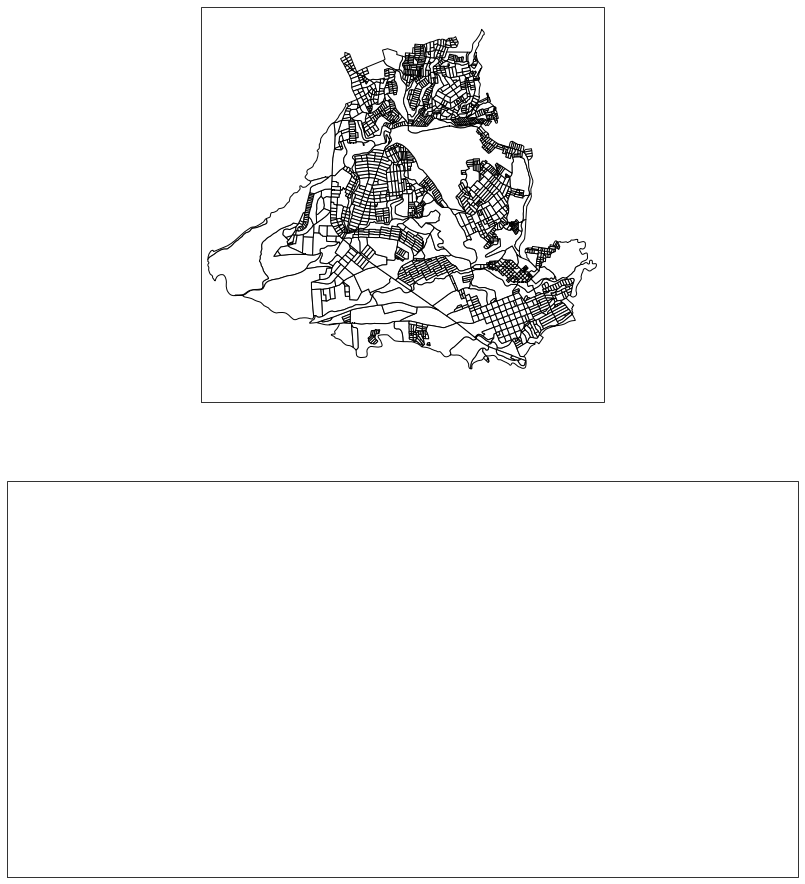

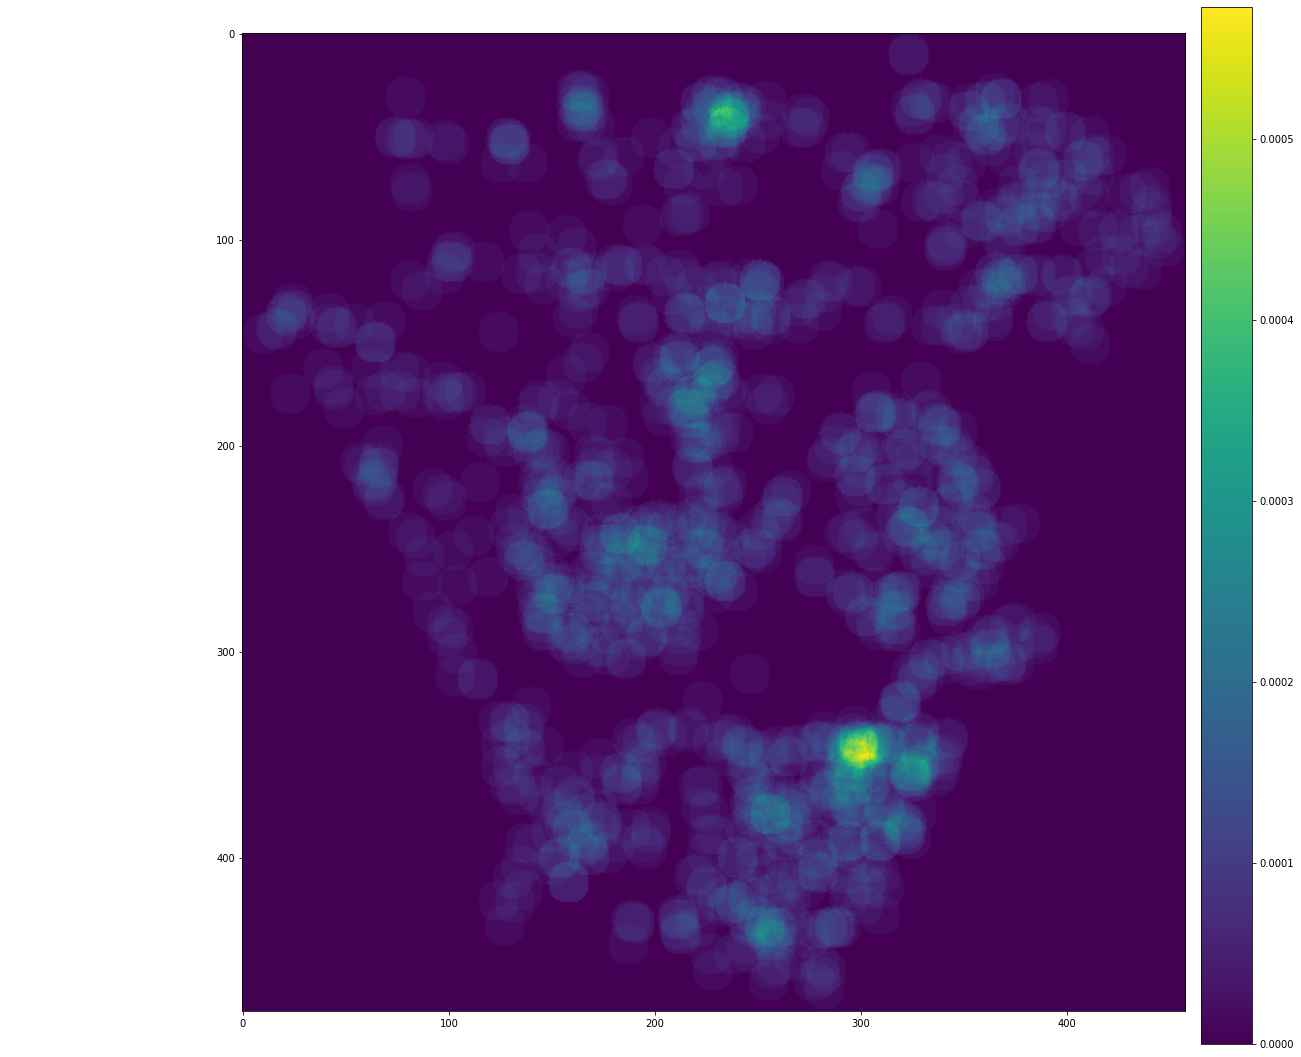

In [33]:
overlapping = 0.150

subplot_kw = dict(projection=ccrs.PlateCarree())

fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 16), subplot_kw=subplot_kw)

# Mapa de floridablanca
lower_lon = -73.125
upper_lon = -73.073
lower_lat = 7.051
upper_lat = 7.102

ax1.set_extent([lower_lon, upper_lon, lower_lat, upper_lat])

reader = shapereader.Reader('68276_manzanas')

for manzana in reader.geometries():
    ax1.add_geometries([manzana], ccrs.PlateCarree(), facecolor='white', edgecolor='black')

#ax.scatter(df['longitud'], df['latitud'], zorder=10, c='r', s=10, alpha=0.2)
#ax.add_line

fig = plt.figure(figsize=(25, 18))
plt.rcParams["figure.autolayout"] = True

#ax = fig.add_subplot(111)
#ax.set_title('Mapa de calor')
plt.imshow(matrix_acc)
ax1.set_aspect('equal')

ax2 = fig.add_axes([0.12, 0.1, 0.78, 0.8])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.patch.set_alpha(0)
ax2.set_frame_on(False)
plt.colorbar(orientation='vertical', pad=0.2)

plt.show()

# K means

In [77]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from numpy import array
from numpy import argmax

In [39]:
dfNormalized = df.copy(deep=True)

In [64]:
dfNormalized = dfNormalized.drop(['fec_not', 'semana', 'año', 'cod_pais_o', 'cod_dpto_o', 'cod_mun_o', 'cod_ase_', 'fecha_contagio', 'inicio_sintomas', 'fec_hos_', 'condicion_final',
                   'fecha_defuncion', 'fecha_nacimiento', 'certif_defuncion', 'familiar_sintomas', 'latitud', 'longitud', 'distancia'], axis=1)

In [95]:
def one_hot_encode(column: str, df: pd.DataFrame):
  data = df[column].values
  values = array(data)

  label_encoder = preprocessing.LabelEncoder()
  integer_encoded = label_encoder.fit_transform(values)

  onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  onehot_encoded_data = [data[0] for data in onehot_encoded]
  
  df[column] = onehot_encoded_data

  return df

In [113]:
dfNormalized = one_hot_encode('sexo_', dfNormalized)
dfNormalized = one_hot_encode('tip_ss_', dfNormalized)
dfNormalized = one_hot_encode('ocupacion_', dfNormalized)
dfNormalized = one_hot_encode('conducta', dfNormalized)

In [115]:
data_list = []
for column in dfNormalized.columns:
  data_list.append(dfNormalized[column])

data_normalized = preprocessing.normalize(data_list)

In [125]:
data_normalized.transpose()

array([[0.01921132, 0.02655595, 0.04065578, ..., 0.03273853, 0.02811793,
        0.02814283],
       [0.01844287, 0.02655595, 0.        , ..., 0.03273853, 0.02810517,
        0.02815664],
       [0.04457027, 0.02655595, 0.        , ..., 0.03273853, 0.02816801,
        0.02819981],
       ...,
       [0.00153691, 0.02655595, 0.        , ..., 0.03273853, 0.02811431,
        0.02820399],
       [0.00922144, 0.02655595, 0.04065578, ..., 0.03273853, 0.02814228,
        0.02808354],
       [0.01075834, 0.02655595, 0.        , ..., 0.        , 0.02821475,
        0.02808953]])

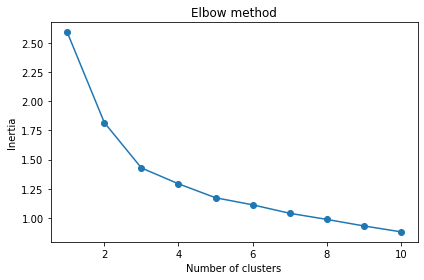

In [126]:
data = data_normalized.transpose()
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [127]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(data)

KMeans()

In [129]:
dfNormalized['labels_'] = kmeans.labels_